# SLT-CE-7: Mean Field Approximation

<p style="background-color:#adebad;">
In this coding exercise we will solve the 2D ising model (aka image riconstruction model) using mean field
approximation.
</p>

# References 

[1] [Lecture slides](https://ml2.inf.ethz.ch/courses/slt/lectures/slt19_lecture06.pdf)

[2] [Exercises](https://ml2.inf.ethz.ch/courses/slt/exercises/exercise10.pdf)

[3] [Tutorial](https://ml2.inf.ethz.ch/courses/slt/tutorials/Tutorial-mean-field-apx.pdf)

[4] [Wine data set](http://archive.ics.uci.edu/ml/datasets/Wine)

[5] Bishop, Christopher M. "Pattern Recognition and Machine Learning." (2006).

[6] [An Introduction to Variational Methods for Graphical Models](https://people.eecs.berkeley.edu/~jordan/papers/variational-intro.pdf)


# Image denoising using mean field approximation

## Task

<p style="background-color:#adebad;">
We will be using the Ising model from the coding exercise 2 for image denoising, also described in Series 10 [2]. Recall that the model orignates from section 8.3.3 of [5]. However, to approximate the inference we will apply mean field approximation and then compare it to the MCMC estimates.
</p>

## Setup

We start by importing necessary python packages.

In [22]:
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
import copy
import time


We load the original image of size 300x300 which we will be trying to reconstruct. White pixels have values -1 and the black pixels are of value +1.

In [3]:
IMG_ORIGINAL = mpimg.imread("flower.png")#[:,:,0]/255
IMG_ORIGINAL[IMG_ORIGINAL > 0.5] = 1
IMG_ORIGINAL[IMG_ORIGINAL <= 0.5] = -1

Check the dimensions of the image

In [4]:
IMG_HEIGHT = IMG_ORIGINAL.shape[0]
IMG_WIDTH = IMG_ORIGINAL.shape[1]
IMG_ORIGINAL.shape

(300, 300)

Plot the original image

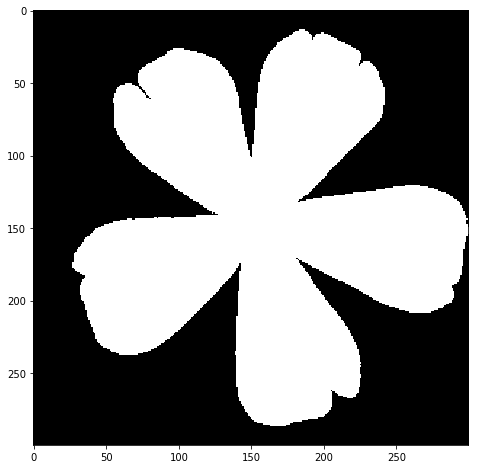

In [5]:
plt.figure(figsize=(8,8))
plt.imshow(IMG_ORIGINAL, cmap='gray')
plt.show()

Generate the noisy version - flip random 30% of pixels. 

In [6]:
# Fix random seed for reproducibility
np.random.seed(13)
def noise_im(IMG_ORIGINAL):
    IMG_NOISY_OBSERVATION = IMG_ORIGINAL.copy()
    num_flips = int(0.3 * IMG_HEIGHT * IMG_WIDTH)

    perm = np.random.permutation(IMG_ORIGINAL.size)[0:int(0.3 * IMG_ORIGINAL.size)]
    for k in perm:
        i = int(k/IMG_WIDTH)
        j = k%IMG_HEIGHT
        IMG_NOISY_OBSERVATION[i,j] = -IMG_NOISY_OBSERVATION[i,j]
    return IMG_NOISY_OBSERVATION

IMG_NOISY_OBSERVATION = noise_im(IMG_ORIGINAL)


    

Plot the noisy version of the original image

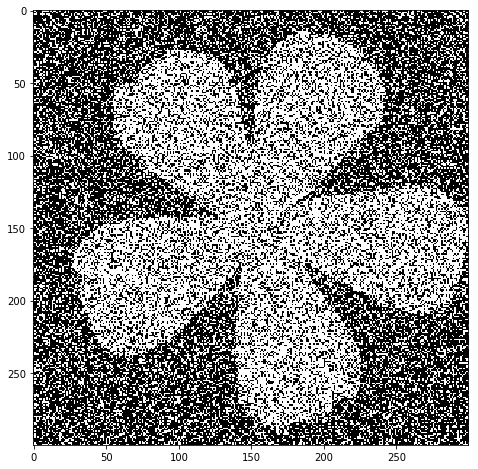

In [7]:
plt.figure(figsize=(8,8))
plt.imshow(IMG_NOISY_OBSERVATION, cmap='gray')
plt.show()

We will fix the parameters of the model as


In [8]:
H = 0.0
Beta = 1.0
Eta = 2.1

Global computation of the energy

In [9]:
def energy(img_estimate, img_noisy_observation):
    """Compute the energy for given estimate 'img_estimate'
    with respect to the  observation 'img_noisy_observation'.

    Args:
            img_estimate (np.ndarray): estimated image matrix
            img_noisy_observation (np.ndarray): noisy image matrix

    Returns:
            energy (float): energy of the estimate given observation
    """
    kernel = np.asarray([[1,1,1],[1,0,1],[1,1,1]])
    neigh_sum = convolve(img_estimate, kernel, mode="constant", cval=0)
    return - np.sum(H * img_estimate + \
                    Eta * img_estimate * img_noisy_observation + \
                    Beta * img_estimate * neigh_sum)

In [10]:
energy(IMG_NOISY_OBSERVATION, IMG_NOISY_OBSERVATION)

-300855.94

Estimating loss via mean squared error

In [11]:
def mse_loss(img_estimate, img_original):
    """Computing mean squared error loss

    Args:
            img_estimate (np.ndarray): estimated image matrix
            img_original (np.ndarray): original image matrix

    Returns:
            mse (float): mean squared error between two matrices
    """
    err = np.sum((img_estimate.astype("float") - img_original.astype("float")) ** 2)
    err /= float(img_estimate.shape[0] * img_estimate.shape[1])
    return err

Auxiliary function for the local energy computation of the implemented MCMC method.

In [12]:
def pixel_energy(img_estimate, img_noisy_observation, i, j):
    """Compute the energy localized around a pixel (i,j)

    Args:
            img_estimate (np.ndarray): estimated image matrix
            img_noisy_observation (np.ndarray): noisy image matrix
            i,j (double, double): pixel coordinates

    Returns:
            energy (float): local energy around given pixel
    """
    return - ( H*img_estimate[i,j]+\
               Beta*img_estimate[i,j]*np.sum(img_estimate[i-1:i+2,j-1:j+2])+\
               Eta*img_estimate[i,j]*img_noisy_observation[i,j])

Display various energies and losses for the noisy image as our initial estimate with respect to the original image.

In [13]:
print(mse_loss(IMG_NOISY_OBSERVATION, IMG_ORIGINAL))
print(energy(IMG_ORIGINAL, IMG_NOISY_OBSERVATION))
print(energy(IMG_NOISY_OBSERVATION, IMG_NOISY_OBSERVATION))

1.2
-773448.0
-300856.0


<h2 style="background-color:#f0b375;">
Section 4.0 
<span style=font-size:50%> Complete all problems in this section to get a pass on this exercise. </span>
</h2>

<p style="background-color:#adebad;">
Shorty describe the theory of the mean field approximation, you can choose to describe only one of the many derivation given in the tutorial [3] (e.g. variational upper bound).  
</p>


<h2 style="background-color:#f0b375;">
Mean Field Approximation
</h2>

The idea behind the mean field approximation is to aproximate a function that is intractable to compute. Thus in many cost fucntions the normalization function is require, and this function has an exponenential number of term. Since the number of terms is so massive, is wont be possible to solve this analytical, so an approximation will be the way to solve this.

For the case of the Ising model, a big number of terms appear in the function when we want to compute the energy function. This includes a term for the contribution of the nearest neighbors.

The approximation is described as follows:

The idea is to minimize the KL-Divergence (D(Q|P)) between a approximation function Q and the target function P, where Q must be choosen to be a factorizable function.

   
By deriving the extremality conditions, the optimal approximation is: 

  $$q_{u}(\alpha) = \frac{e^{-\beta h_{u\alpha}}}{\sum_{\nu}e^{-\beta h_{u\nu}}}$$


that defines the assignment probability of an object $u$ to a cluster $\alpha$ and where the term $h_{u\alpha}$ is refered as the mean field, that reflects the expected cost under the constraints that object $u$ is assigned to cluster $$\alpha$$. The mean field $$h_{u\alpha}$$ is defined as: $$h_{u\alpha} = E_{Q_ {u \rightarrow \alpha}}\{R(c)\} = \sum_{c \in C}\prod_{i \neq u \leq n} q_i(c(i))\mathbb{I}_{\{c(u) = \alpha\}}R(c)$$

That is calculted in by a iterative, asynchronous updating algorith that maximizes the expectation.


<p style="background-color:#adebad;">
With the help of [2], explain the algorithm for solving image denoising using mean field approximation:
</p>

<h2 style="background-color:#f0b375;">
Image Denoising
</h2>

In the  case of the image denoising, an image has a $\sigma$ to be minimized:
$$E(\sigma) = -\lambda \sum_{i=1}^N h_i\sigma - \sum_{i,j = 1}^N J_{i,j} \sigma_i \sigma_j$$ where $h_i$ is value of each pixel $i$ from the noisy observated image.

Therfore, the idea isto minimize KL(p_0 || p) + F($\beta$), that is equivalent to minimize the Gibbs free energy G(p).
F($\beta$) is the free energy, $p_0$ a proposed distribution and $p$ the true distribution.

It can be shown that: $$G(p) = -\lambda \sum_{i=1}^N m_i h_i - \sum_{i=1}^{N-1} \sum_{j=i+1}^N m_i J_{ij} m_j + 1/\beta \sum_{i=1}^N (\frac{1 + m_i}{2}log \frac{1 + m_i}{2} + \frac{1 - m_i}{2}log\frac{1 - m_i}{2})$$

where $m_i$ is the mean field for pixel $i$. 

Deriving the stationary equations $G(p)$ can be minimized by:

$$m_k = tanh(\beta(\sum_{i\neq k} J_{ki} m_i + \lambda h_k)), k \in {1,N}$$

that can solved iteratively by updating $m_k$.

<p style="background-color:#adebad;">
Implement mean field algorithm for image denoising. You are provided with an implementation of the metropolis algorithm as a representative of MCMC, for the sake of comparison. Note that the epochs parameter below is introduced solely to ease the plotting procedure and it is up to you assign the semantics to it.
Evaluate your mean field implementation using 'evaluate' function, and compare your results to MCMC. Clearly explain the differences. Does it converge faster? What are the disadvantages and advantages?
Consider running the comparison on another image to prove your point.
Also, feel free to replace our implementation of MCMC with your own.
</p>

In [14]:
def metropolis(img_noisy_observation, img_original, epochs):
    """Do the metropolis sampling starting from the noisy observation as
    our initial estimate. Repeat sampling for a given number of epochs.

    Args:
            img_noisy_observation (np.ndarray): noisy image matrix
            img_original (np.ndarray): original image matrix
                - Note: we use it only so we can keep track of the
                  MSE drop i.e. for the plotting purposes.
            epochs (int): number of iterations

    Returns:
            img_estimate (np.ndarray): return reconstucted estimate of the original
            energies (np.ndarray): energies recorded in arbitary moments during 
                                      the sampling process, for plotting purposes
            losses (np.ndarray): MSE loss wrt original image recorded in arbitary 
                                 moments during the sampling process, for plotting purposes
    """
   
    img_estimate = img_noisy_observation.copy()
    img_estimate_padded = np.pad(img_estimate, 1, mode='constant', constant_values=0)
    img_noisy_observation_padded = np.pad(img_noisy_observation, 1, mode='constant', constant_values=0)

    T = 1.0

    energy_vals = []
    loss = []

    for e in range(epochs):
        for i in range(1,img_original.shape[0]+1):
            for j in range(1,img_original.shape[1]+1):
                # calculate local energy
                pixel_cur_energy = pixel_energy(img_estimate_padded, img_noisy_observation_padded, i, j)
                # flip the pixel
                img_estimate_padded[i,j] = -img_estimate_padded[i,j]
                # calculate new local energy
                pixel_new_energy = pixel_energy(img_estimate_padded, img_noisy_observation_padded, i, j)
                # energy difference
                dE = pixel_new_energy - pixel_cur_energy
                # do metropolis thingy
                if dE > 0:
                    p = 0.5*(1-np.tanh(0.5 / T * dE))
                    rr = np.random.rand(1)
                    if rr > p:
                        # revert back pixel
                        img_estimate_padded[i,j] = -img_estimate_padded[i,j]
                    # append energy
                if j % 200 == 0:
                    energy_vals.append(energy(img_estimate_padded[1:-1,1:-1],img_noisy_observation))
                    loss.append(mse_loss(img_estimate_padded[1:-1,1:-1],img_original))

    return img_estimate_padded[1:-1,1:-1], np.asarray(energy_vals), np.asarray(loss)

In [36]:
def meanfield(img_noisy_observation, img_original, epochs, Lambda = 2.0, beta=1.0, Filter=3, NW=0.1):
    """Do the meanfield approximation to estimate the reconstruction.

    Args:
            img_noisy_observation (np.ndarray): noisy image matrix
            img_original (np.ndarray): original image matrix
                - Note: we use it only so we can keep track of the
                  MSE drop i.e. for the plotting purposes.
            epochs (int): number of iterations

    Returns:
            img_estimate (np.ndarray): return reconstucted estimate of the original
            energies (np.ndarray): energies recorded in arbitary moments during 
                                      the sampling process, for plotting purposes
            losses (np.ndarray): MSE loss wrt original image recorded in arbitary 
                                 moments during the sampling process, for plotting purposes
    """
    # Your code should replace the following code, which is given as a placeholder
    # and demonstrates how the returned values are used in the rest of the code
    energies = []
    losses = []
    E = energy(img_noisy_observation, img_noisy_observation)
    L = mse_loss(img_noisy_observation, img_original)
    #NE Neighbor width
    #NS Neighbor sum
    # artifically construct energies and losses arrays
    m = copy.copy(img_noisy_observation)
    for i in range(600000):
        j, k = np.random.randint(m.shape[0], size=2)
        #allocating memory for filter matrix
        FM = np.zeros(m.shape) #filter matrix
        FM[j- Filter:j+Filter + 1,k- Filter:k+Filter + 1] = 1 / NW
        FM[j, k] = 0
        NS = np.sum(np.multiply(FM, m))
        m[j,k] = np.tanh(beta * (NS + Lambda * img_noisy_observation[j, k]))
        if i % 200 == 0:
            energies.append(energy(m,img_noisy_observation))
            losses.append(mse_loss(m,img_original))

    return m, np.asarray(energies), np.asarray(losses)


In [37]:
def evaluate(method, img_noisy_observation, img_original, epochs=1):
    """ Given an inference method, we will run the estimation procedure 
    for the specifed number of epochs. We measure time and reconstruction
    efficiency.

    Args:
            method (function pointer): sampling method
            img_noisy_observation (np.ndarray): noisy image matrix
            img_original (np.ndarray): original image matrix
            epochs (int): number of epochs to run the sampling
    """
    # Run specified sampling method
    start_time = time.time()
    img_estimate, energies, losses = method(img_noisy_observation, img_original, epochs)
    execution_time = time.time() - start_time
    # Plot energy and MSE drop
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
    ax1.plot(energies)
    ax1.set_title('Energy Drop')
    ax2.plot(losses)
    ax2.set_title('MSE Loss Drop')
    ax3.imshow(img_estimate, cmap='gray')
    ax3.set_title('Reconstruction')
    ax3.get_xaxis().set_visible(False)
    ax3.get_yaxis().set_visible(False)
    plt.suptitle("Executed in approx. "+str(int(execution_time)) + " seconds")
    # show plots
    plt.show()

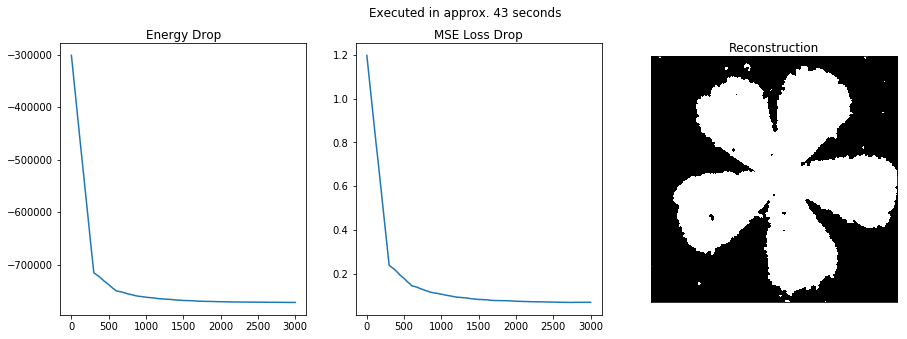

In [18]:
evaluate(metropolis, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 10)

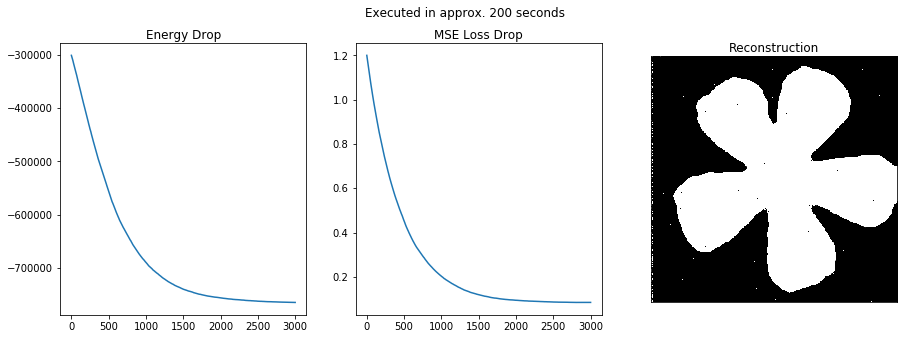

In [38]:
# Evaluate your imlementation of the meanfield
evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 10)

<p style="background-color:#adebad;">
Compare and analyze performance
</p>

In [ ]:

Both Algorithms seem to have similar losses, however
the meanfield approximation gives an smoothed effect in the edges pixels of the image. 
The reason for this diffference is that the metropolis algorithm 
has an steeper initial energy drop, compared to the progresive decrease on the
energy in the other algorithm. 
In the case of the image reconstruction, the metropolis has more 
clusters of wrong pixels. On the other hand the mean field 
approximation gives away more wrong scattered wrong pixels.

Finally, number of neighbors for a given pixel and thier higher assignated weights
is a convergence issue and $\lambda$ regulates how good is a result.

<h2 style="background-color:#f0b375;">
Section 4.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.5 </span>
</h2>

<p style="background-color:#adebad;">
Comment on the convergence of the method. How can we tell if the mean field convereged? Do we always reach the global optimum?
</p>

In [34]:
The converge depends on the gradient of the energy that is a function of the time $E(t)/dt$. As well, the
approximation will converge if $E(t)/dt &lt; \epsilon$ for a small $\epsilon$. 
Findin the global optimum of the loss function is not guaranted, because the algorithm might minize
the energy in a way that does not lead a minimization of the loss.
Findin he global optimum of the energy function is not guarantee too, because the initial noisy image has
random noise and the neighboorhs of the pixels are random too, so the function can get stuck in a local minima.

SyntaxError: invalid syntax (<ipython-input-34-4a80b78b29f1>, line 1)

<h2 style="background-color:#f0b375;">
Section 5.0
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.0 </span>
</h2>

<p style="background-color:#adebad;">
How do the parameters of the Ising model, and the tempereature affect the performance of the mean field?
Plot image reconstructions for different settings of the model parameters (at least 10 experiments). Also, plot the reconstruction with varying parameters of the mean field algorithm. Can you explain the behaviour? Do you see a difference in the reconstraction at different temperature?
</p>

In [ ]:
Effect of lambda

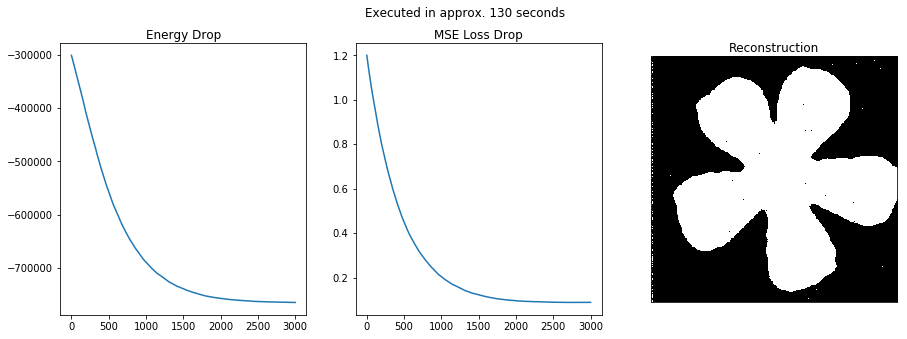

Lambda = 0.001


In [58]:
Lambda = 0.001
evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, Lambda)
print("Lambda = 0.001")

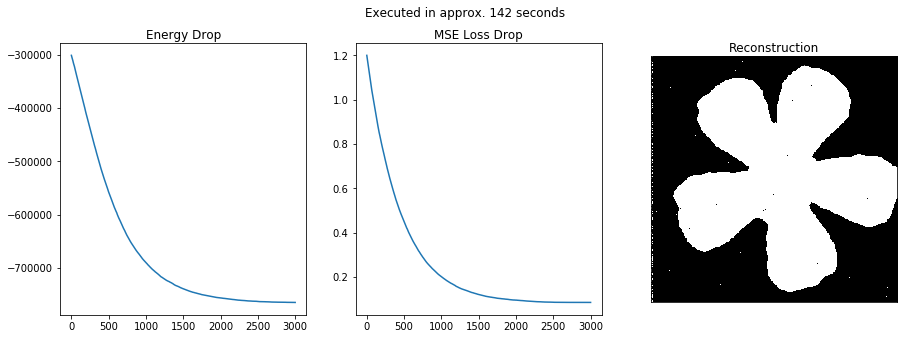

Lambda = 1


In [59]:
Lambda = 1
evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, Lambda)
print("Lambda = 1")

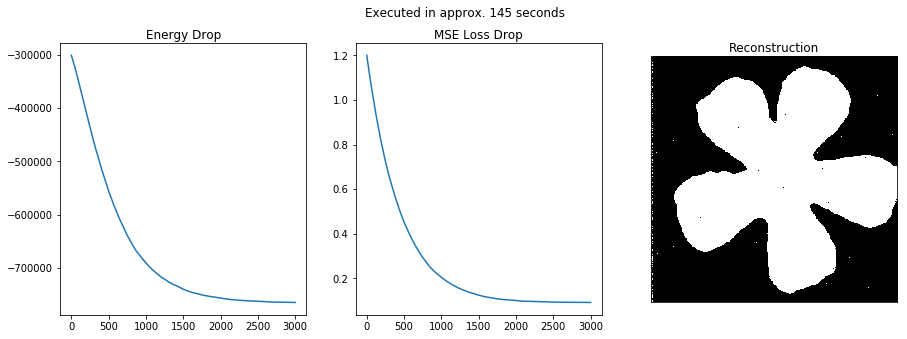

Lambda = 10


In [60]:
Lambda = 10
evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, Lambda)
print("Lambda = 10")

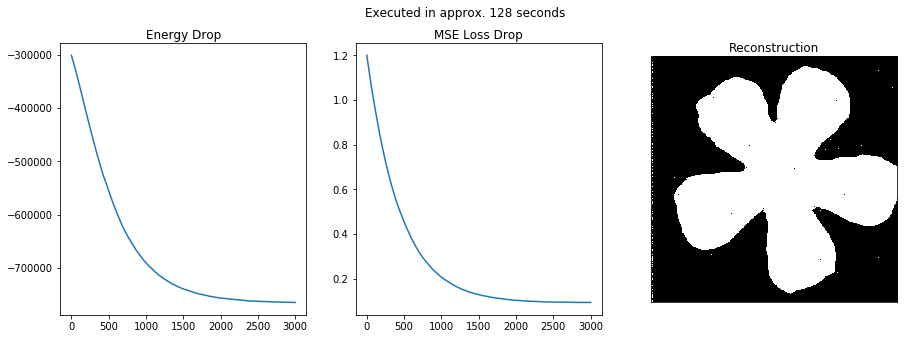

Lambda = 100


In [61]:
Lambda = 100
evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, Lambda)
print("Lambda = 100")

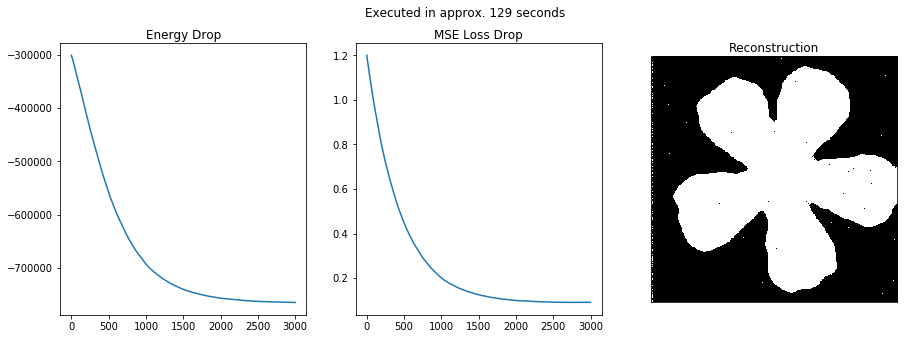

Lambda = 1000


In [62]:
Lambda = 1000
evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, Lambda)
print("Lambda = 1000")

In [57]:
Effect of the neighbourhods around each pixel
Larger neighbourhoods led to smother reconstructions

SyntaxError: invalid syntax (<ipython-input-57-f74457ee6e11>, line 1)

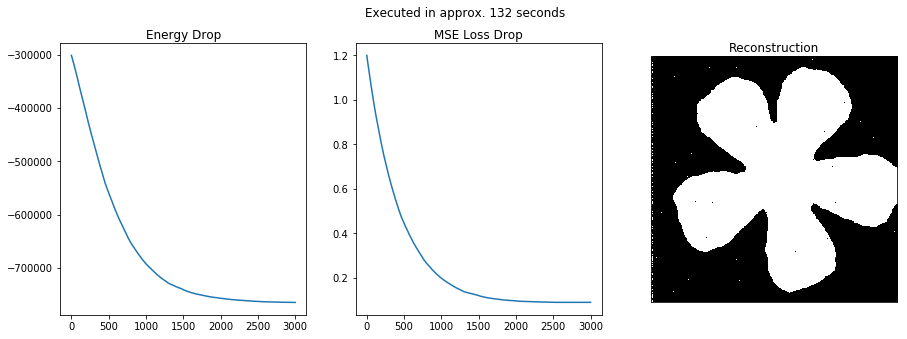

Neighbouhood = 1 


In [63]:
Filter = 1
evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, Filter)
print("Neighbouhood = 1 ")

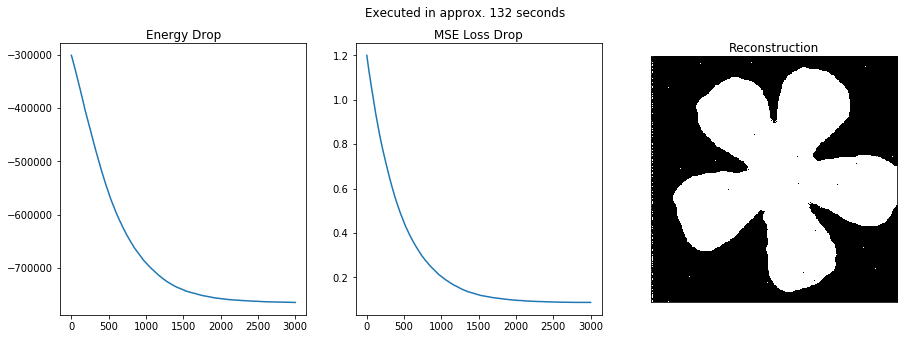

Neighbouhood = 3 


In [64]:
Filter = 3
evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, Filter)
print("Neighbouhood = 3 ")

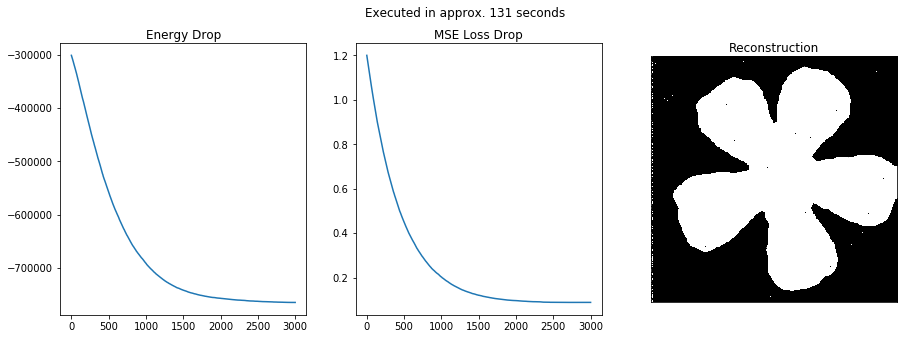

Neighbouhood = 6 


In [65]:
Filter = 6
evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, Filter)
print("Neighbouhood = 6 ")

In [ ]:
Effect of $J_{ik}$ parameters.

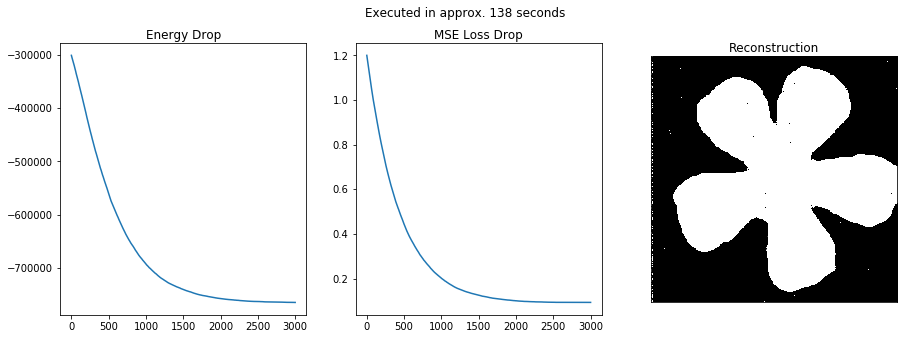

Neighboring Weight = 0.001 


In [66]:
NW = 0.001
evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, NW)
print("Neighboring Weight = 0.001 ")

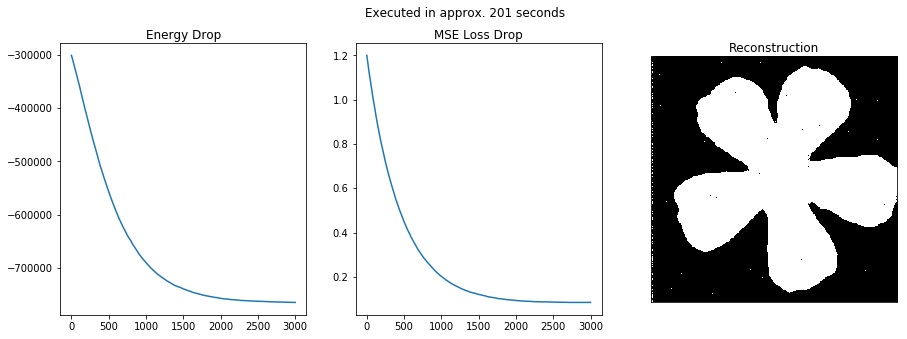

Neighboring Weight = 0.01 


In [49]:
NW = 0.01
evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, NW)
print("Neighboring Weight = 0.01 ")

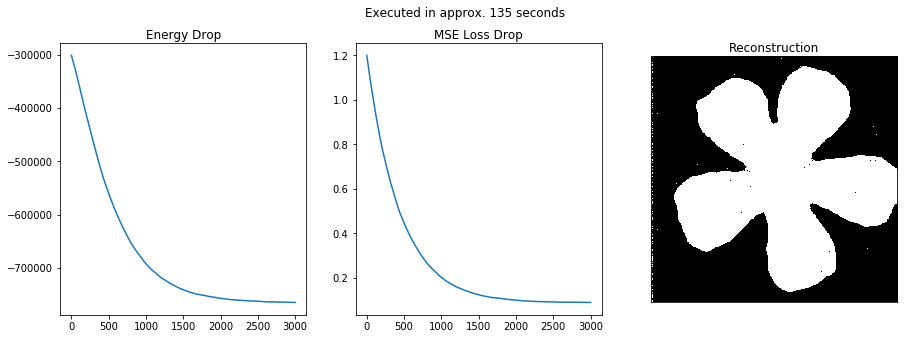

Neighboring Weight = 0.5 


In [67]:
NW = 0.5
evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, NW)
print("Neighboring Weight = 0.5 ")

In [ ]:
Effect of beta

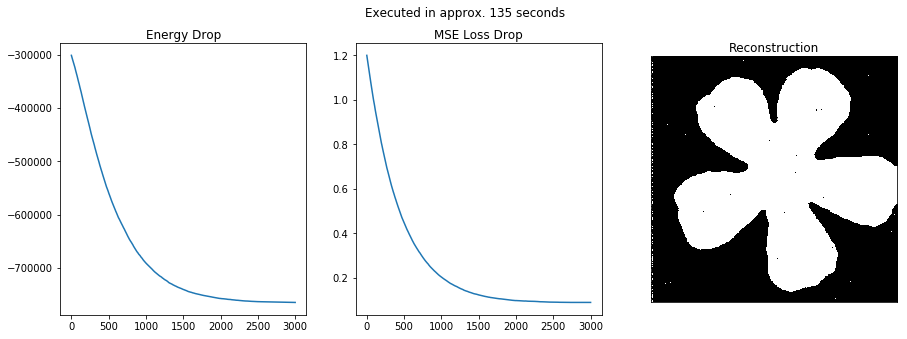

beta = 0.0001


In [68]:

beta = 0.00001
evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, beta)
print("beta = 0.0001")

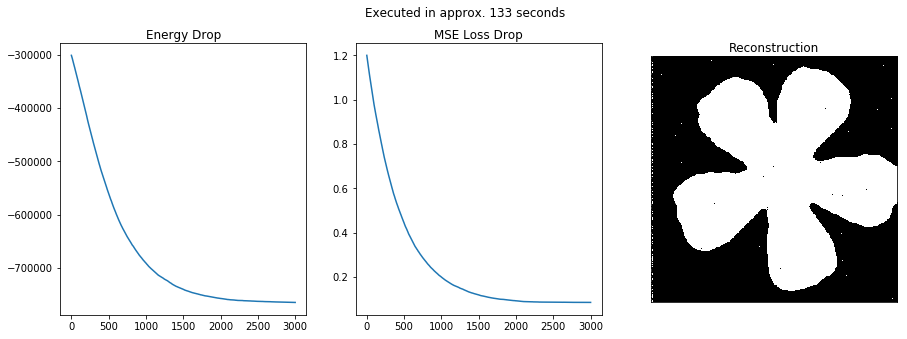

beta = 100


In [69]:

beta = 100
evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, beta)
print("beta = 100")

<h2 style="background-color:#f0b375;">
Section 5.5
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.5 </span>
</h2>

<p style="background-color:#adebad;">
For this part of the task please use the Wine data set (different one than before, see [4]). It contains three classes, see more detailed description online. Implement both, plain-vanilla k-means and smooth k-means in mean field [1] and compare them on the Wine data set.
</p>

<h2 style="background-color:#f0b375;">
Section 6.0
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 6.0 </span>
</h2>

<p style="background-color:#adebad;">
Visualize the clustering by embedding the data to 2D and indicate the labeling by k-means compared
to the ground truth.
</p>

<p style="background-color:#adebad;">
Use the available labels (1-3) to assess the cluster purity and comment on the observed vs. the expected
effect of smooth k-means.
</p>

<p style="background-color:#adebad;">
Evaluate the BIC score for both algorithms (make use of the meanfield-approximation for smooth
k-means). Does it indicate 3 clusters? How does the smooth k-means clustering solution change changing the temperature of the mean field approximation?
</p>

## Comments

We hope you found this exercise instructive.

Feel free to leave comments below, we will read them carefully.